## Getting Started

In [28]:
# Check whether runtime is connected
print("Hello world!")

Hello world!


In [29]:
# General imports
import os
import joblib
import random
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

In [30]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [31]:
crop_df = pd.read_csv("../data/crop.csv")

crop_df.head(10)

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
5,69,37,42,23.058049,83.370118,7.073454,251.055000,rice
6,69,55,38,22.708838,82.639414,5.700806,271.324860,rice
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice
9,68,58,38,23.223974,83.033227,6.336254,221.209196,rice


## EDA

### Crop Recommendation Dataset

In [32]:
crop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [33]:
crop_df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


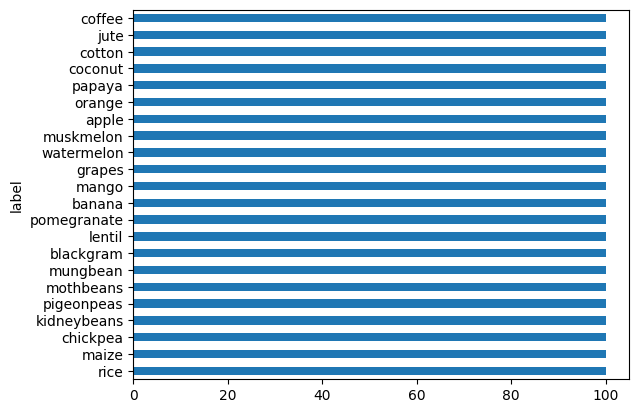

In [34]:
crop_df["label"].value_counts().sort_values().plot(kind="barh")
plt.show()

There is no class imbalance in the crop recommendation dataset.

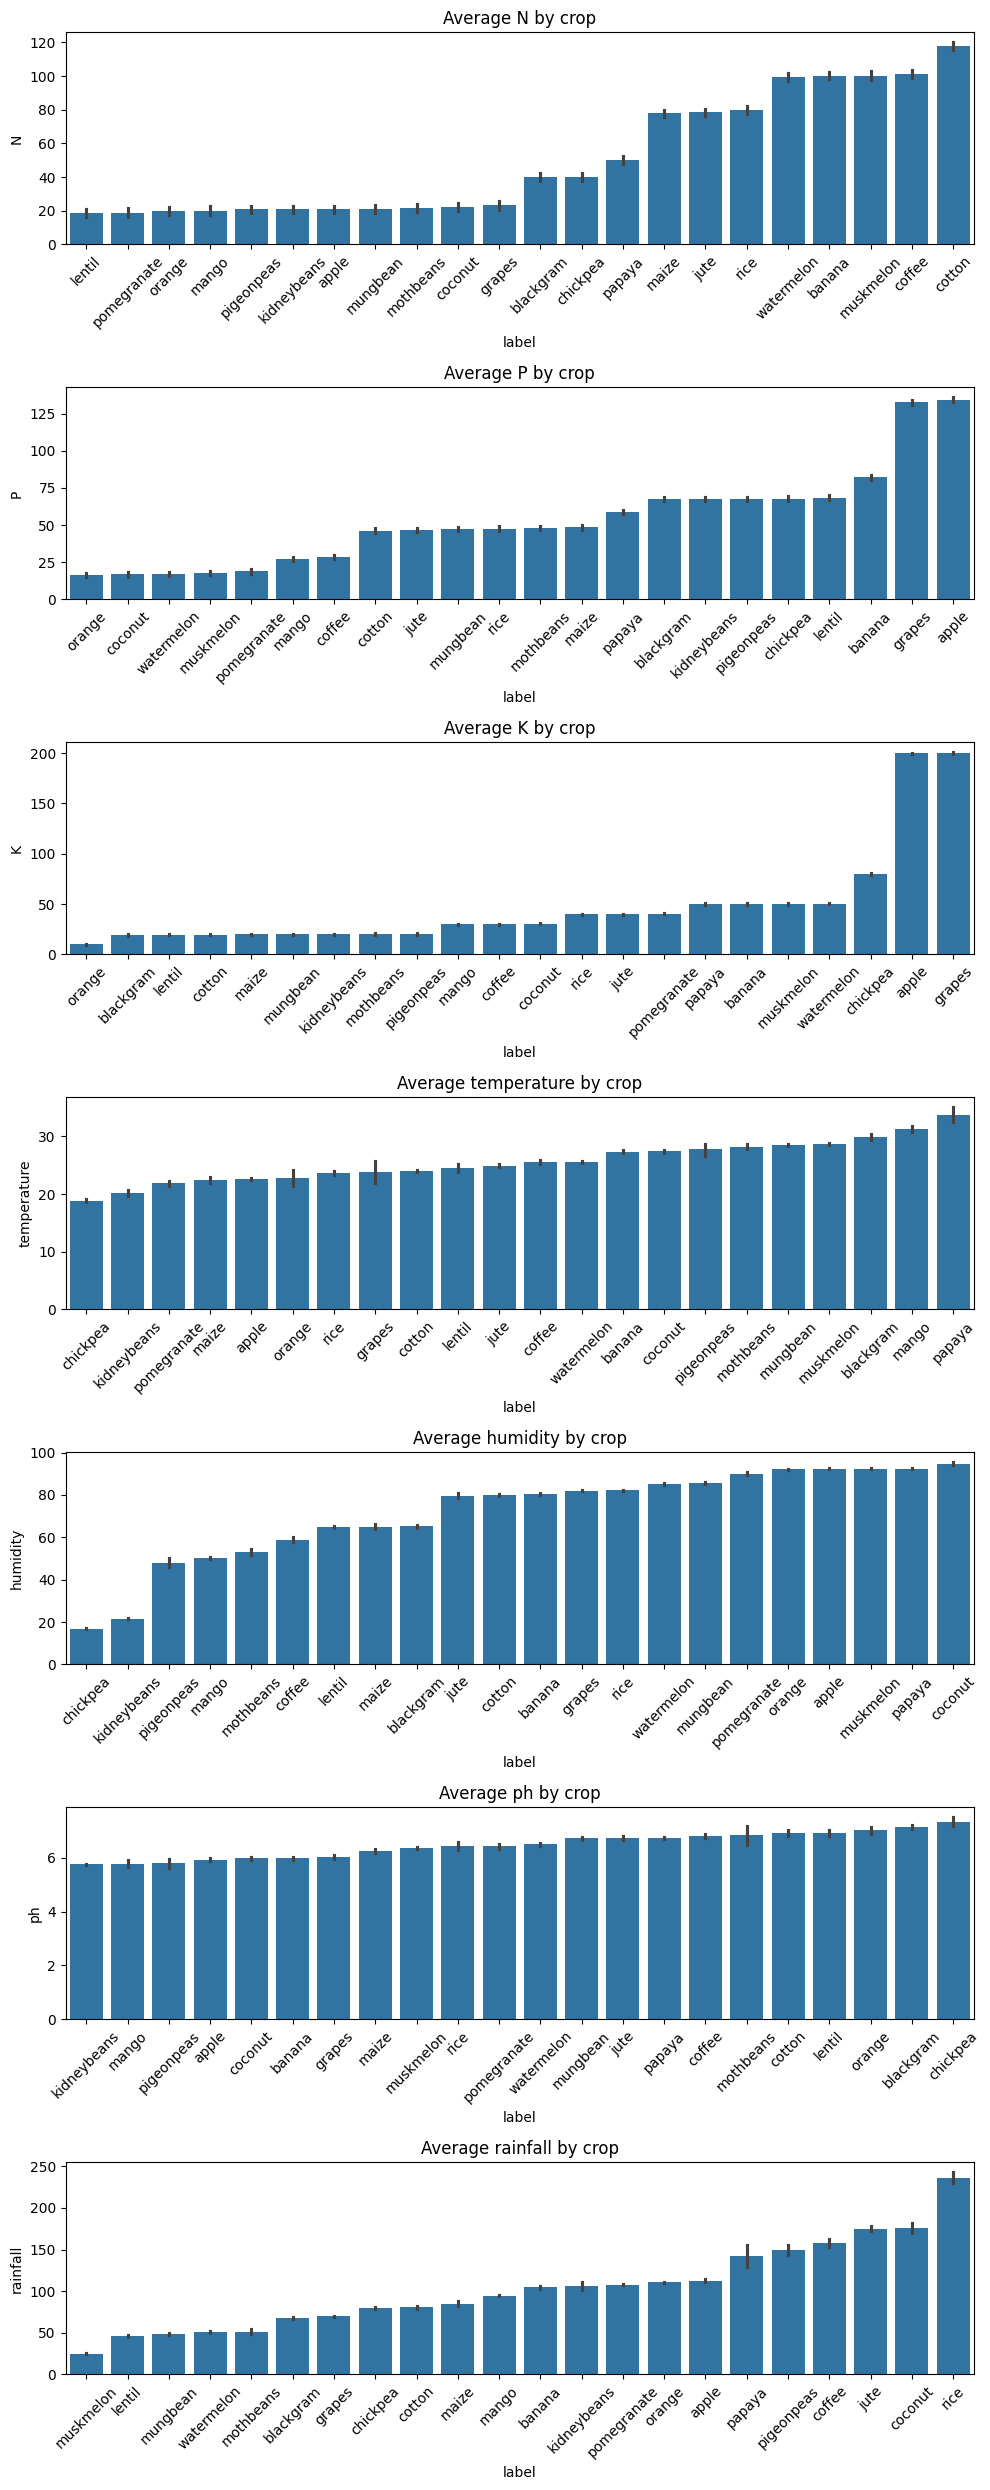

In [35]:
features = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]

plt.figure(figsize=(10, 25))
for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    sns.barplot(
        x="label",
        y=feature,
        data=crop_df,
        estimator="mean",
        order=crop_df.groupby("label")[feature].mean().sort_values().index,
    )
    plt.title(f"Average {feature} by crop")
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

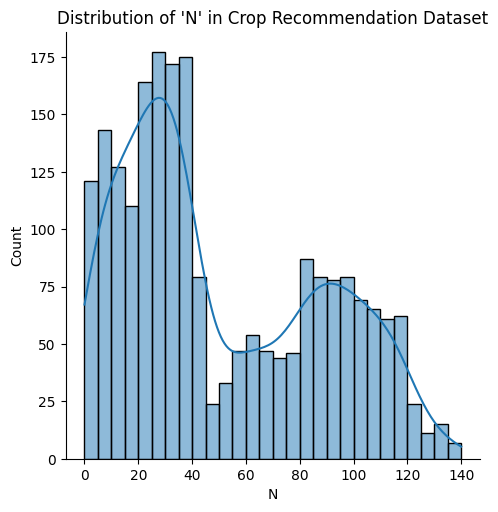

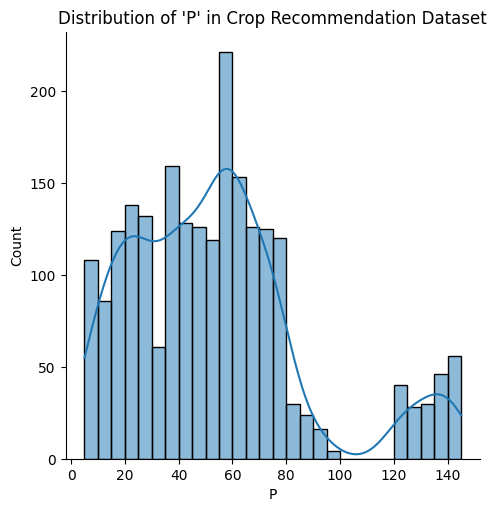

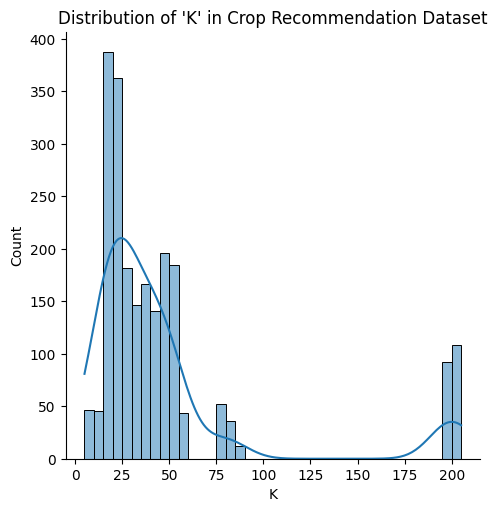

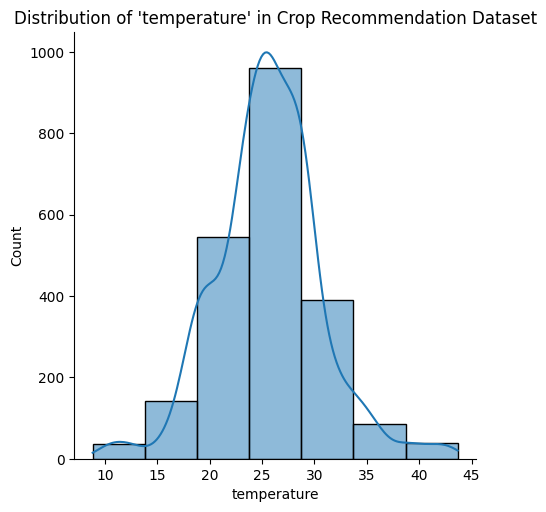

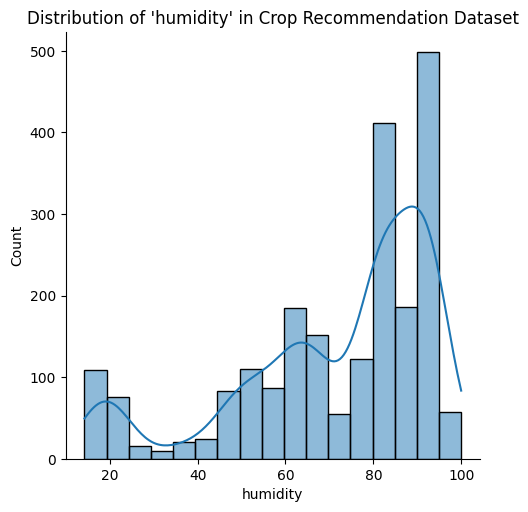

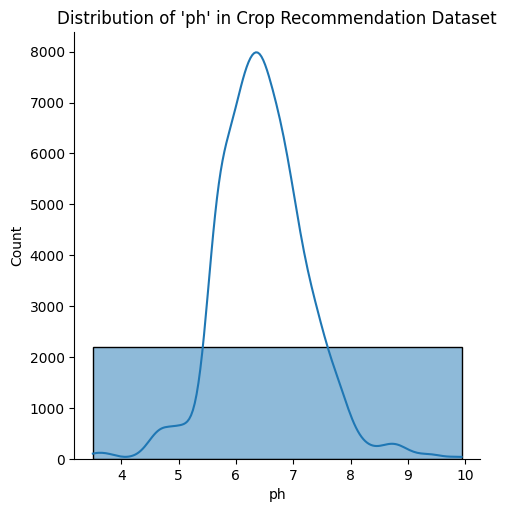

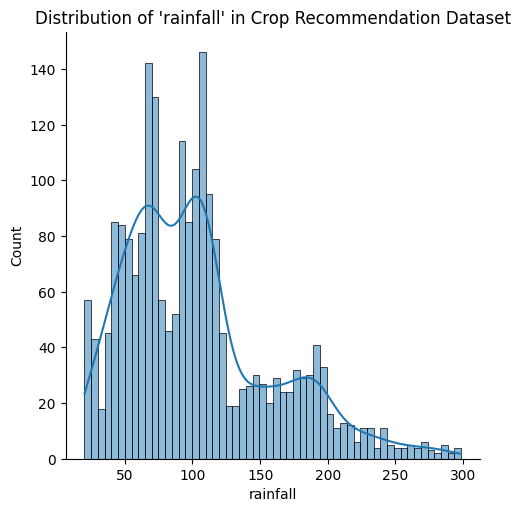

In [36]:
crop_numerical_features = crop_df.select_dtypes("number").columns.tolist()

for feature in crop_numerical_features:
    sns.displot(crop_df, x=feature, binwidth=5, kde=True)
    plt.title(f"Distribution of '{feature}' in Crop Recommendation Dataset")
    plt.show

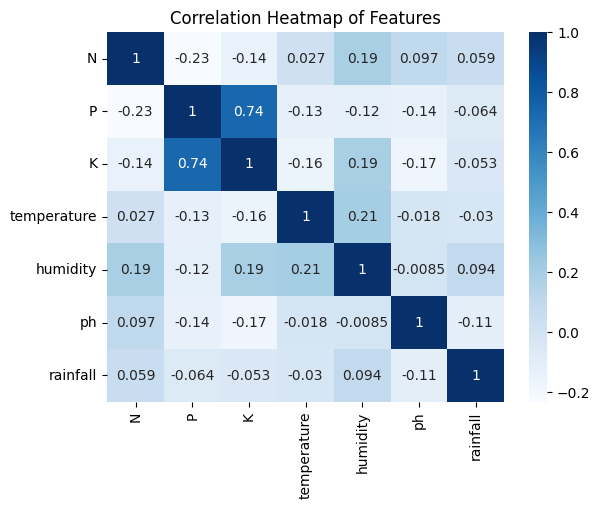

In [37]:
# Correlation heatmap for crop recommendation dataset

corr = crop_df.select_dtypes("number").corr()

sns.heatmap(
    corr,
    cmap="Blues",
    annot=True,
)
plt.title("Correlation Heatmap of Features")
plt.show()

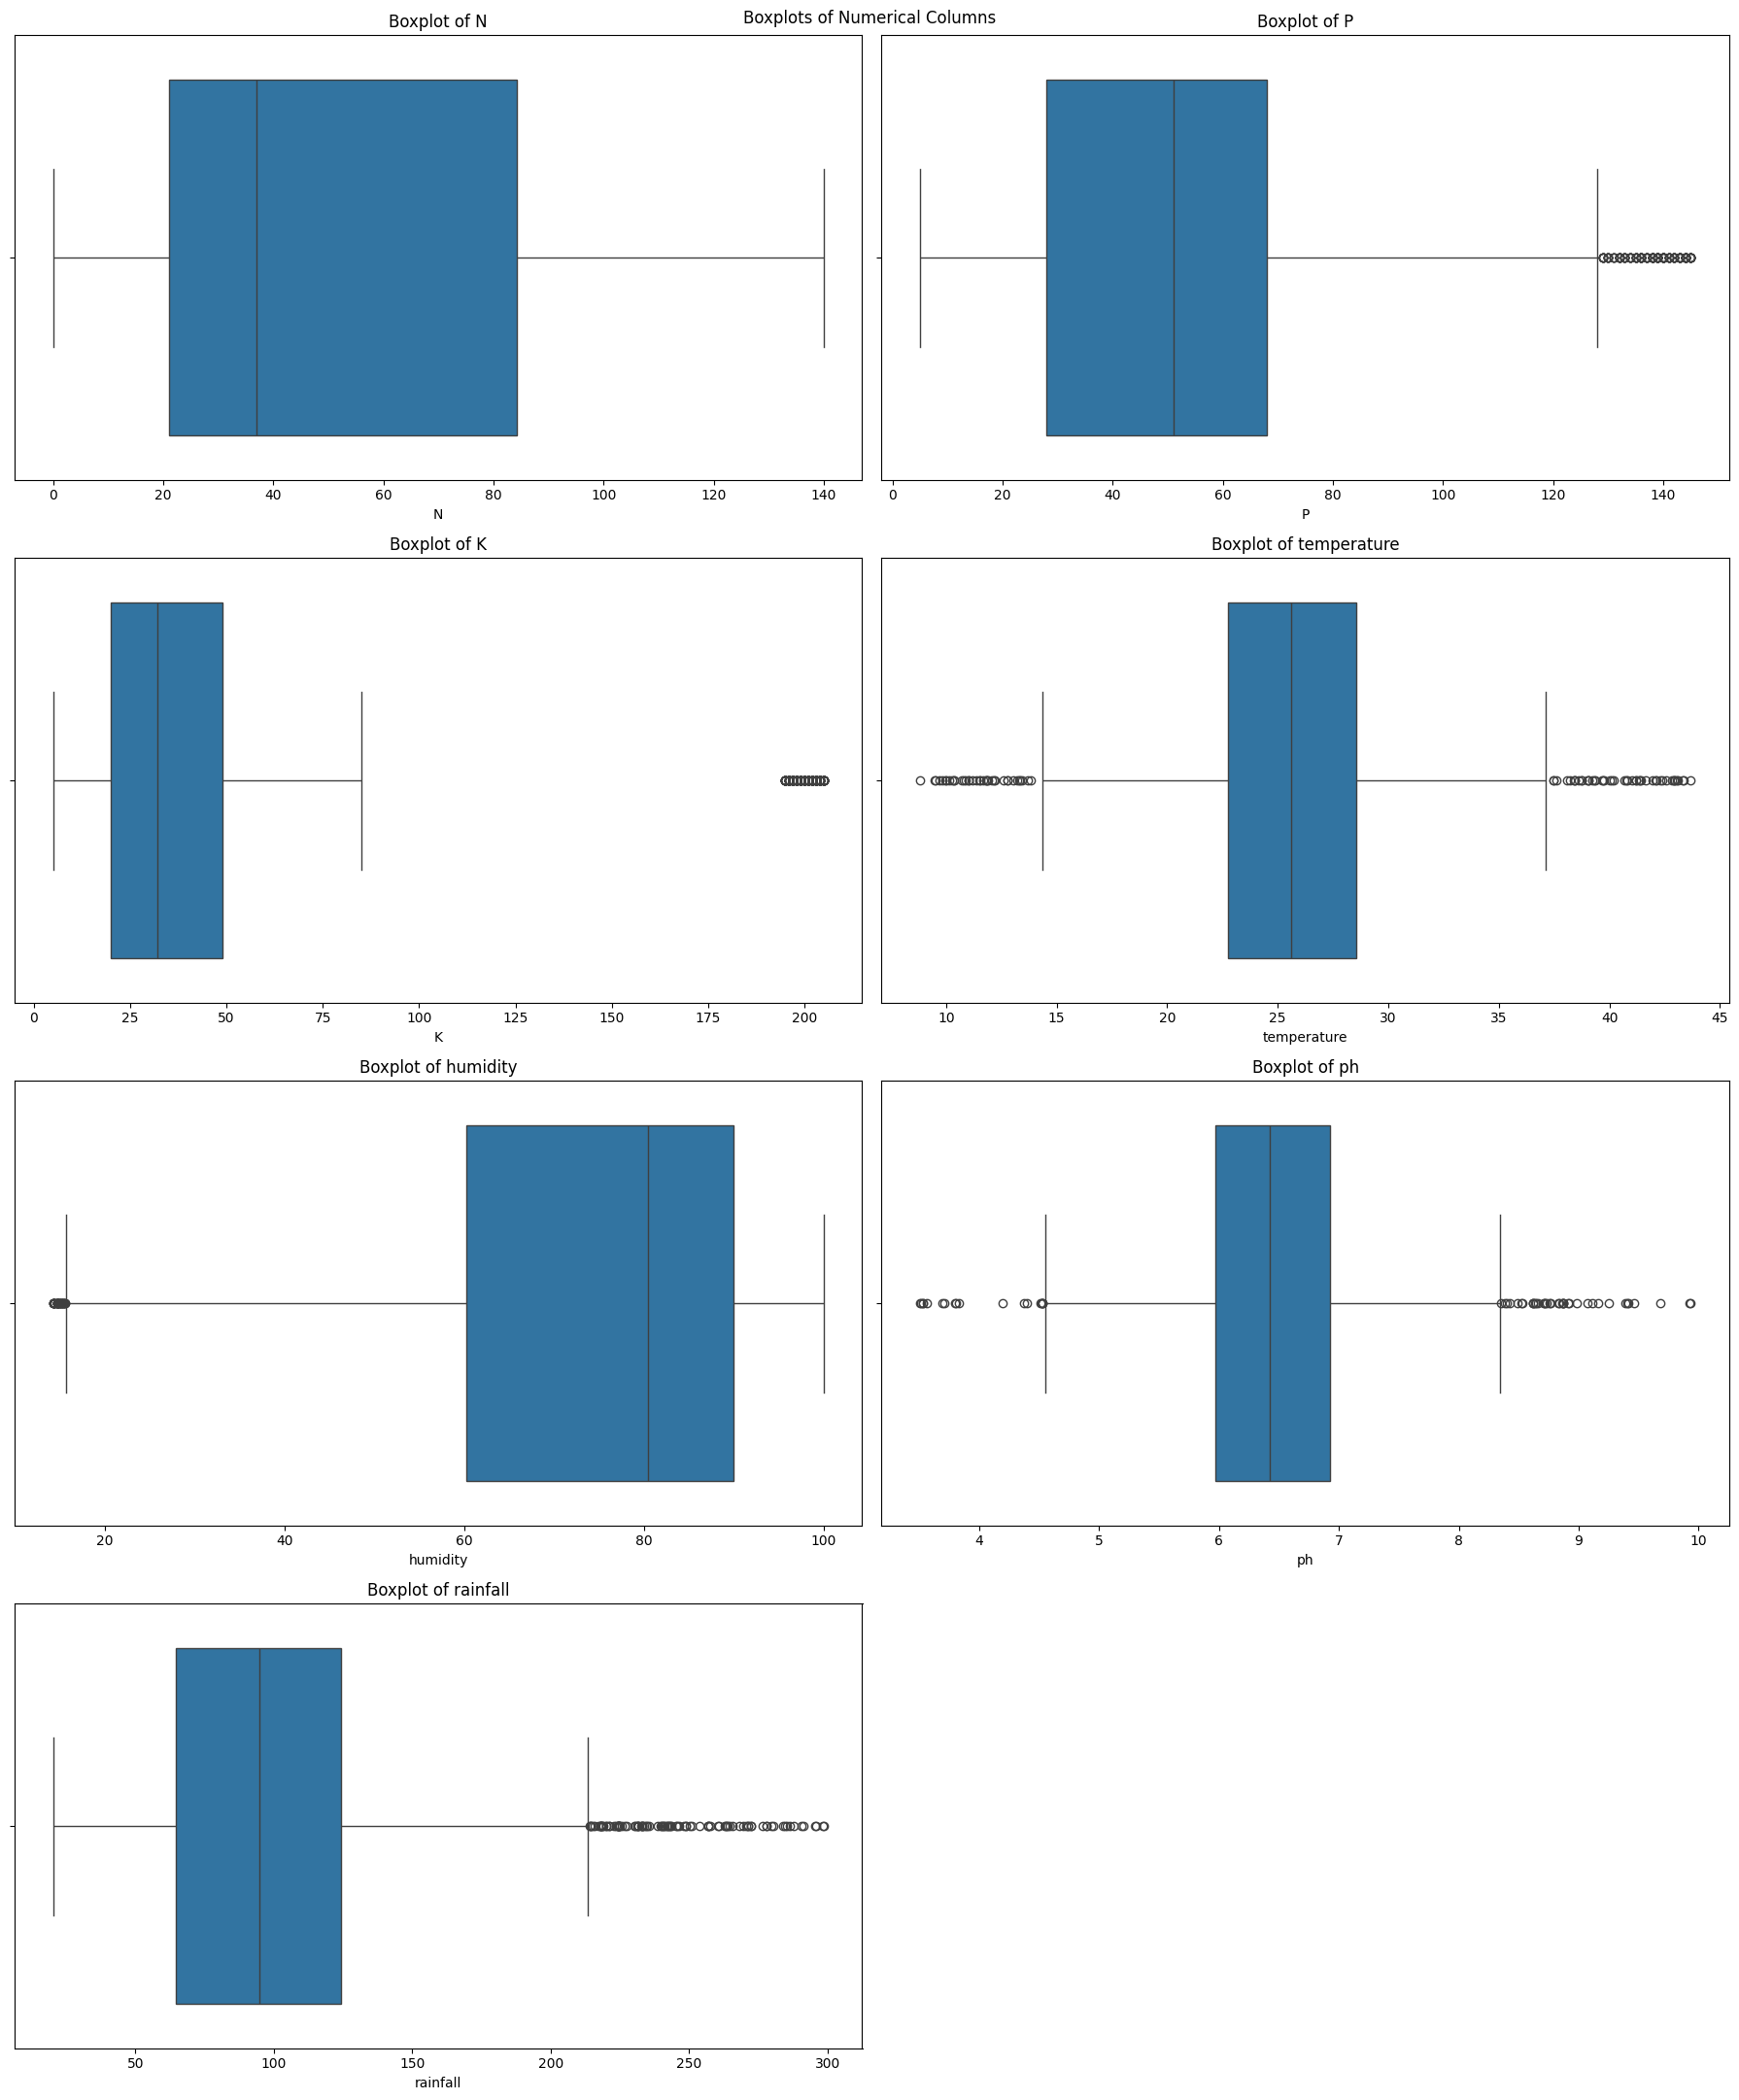

In [38]:
# Box plots for each numerical column
numerical_cols = crop_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
#print(f"\nNumerical columns for outlier analysis: {numerical_cols}")
plt.figure(figsize=(18,22))

for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=crop_df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.suptitle('Boxplots of Numerical Columns')
plt.tight_layout()
plt.show()

In [39]:
cols_with_outliers = []


def find_outliers_IQR(df: pd.DataFrame):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outliers = df[((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR)))]
    return outliers


for feature in crop_numerical_features:
    outliers = find_outliers_IQR(crop_df[feature])
    print(f"Number of outliers in '{feature}' column: {len(outliers)}")
    if len(outliers) != 0:
        cols_with_outliers.append(feature)

print(f"\nColumns with outliers: {cols_with_outliers}")

Number of outliers in 'N' column: 0
Number of outliers in 'P' column: 138
Number of outliers in 'K' column: 200
Number of outliers in 'temperature' column: 86
Number of outliers in 'humidity' column: 30
Number of outliers in 'ph' column: 57
Number of outliers in 'rainfall' column: 100

Columns with outliers: ['P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


## Data Preprocessing

In [40]:
# Remove Outliers Using the IQR Method
Q1 = crop_df[numerical_cols].quantile(0.25)
Q3 = crop_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask for rows without outliers
mask = ~((crop_df[numerical_cols] < lower_bound) | (crop_df[numerical_cols] > upper_bound)).any(axis=1)

# Filter out rows with outliers
df_cleaned = crop_df[mask]
print(f"Original dataset size: {crop_df.shape}")
print(f"Dataset size after removing outliers: {df_cleaned.shape}")

Original dataset size: (2200, 8)
Dataset size after removing outliers: (1768, 8)


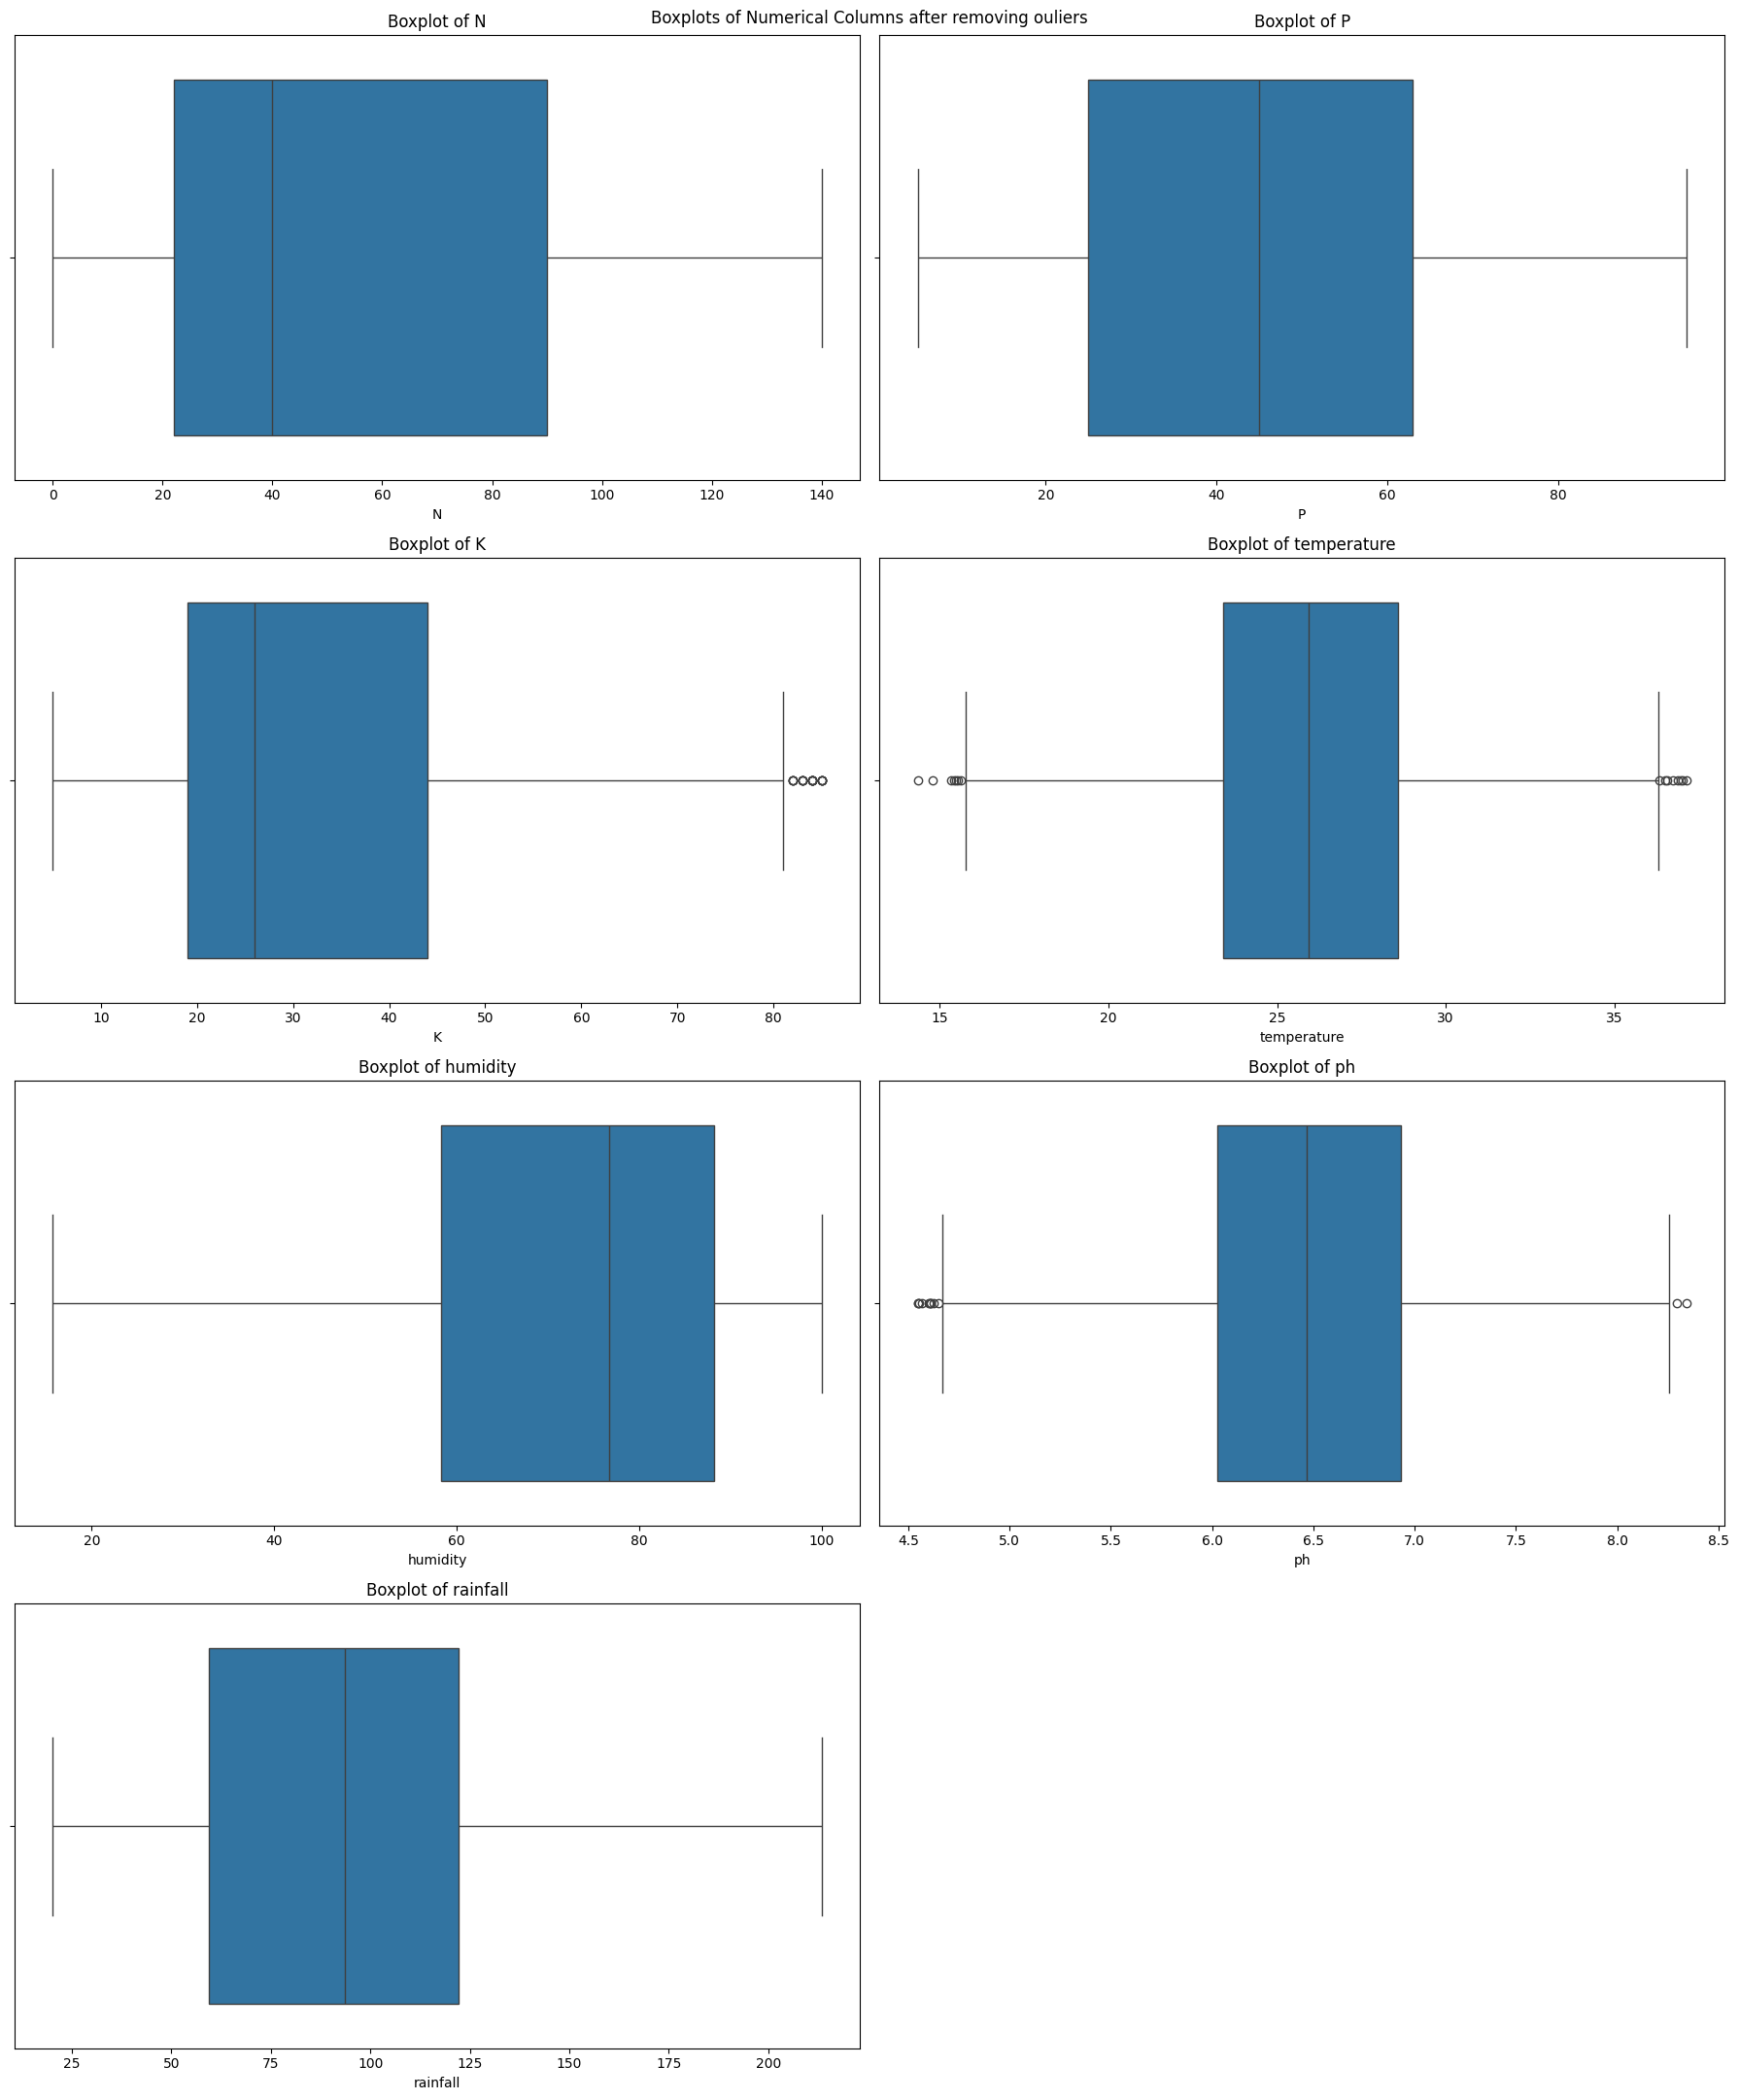

In [41]:
# Box plots for each numerical column after removing ouliers
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
plt.figure(figsize=(18,22))

for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df_cleaned[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.suptitle('Boxplots of Numerical Columns after removing ouliers')
plt.tight_layout()
plt.show()

In [42]:
# Encode labels

encoder = LabelEncoder()
crop_df["encoded_label"] = encoder.fit_transform(crop_df["label"])

crop_df.head(10)

,N,P,K,temperature,humidity,ph,rainfall,label,encoded_label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,20
5,69,37,42,23.058049,83.370118,7.073454,251.055000,rice,20
6,69,55,38,22.708838,82.639414,5.700806,271.324860,rice,20
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice,20
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice,20
9,68,58,38,23.223974,83.033227,6.336254,221.209196,rice,20


In [43]:
crop_df.tail(10)

,N,P,K,temperature,humidity,ph,rainfall,label,encoded_label
2190,103,40,30,27.309018,55.196224,6.348316,141.483164,coffee,5
2191,118,31,34,27.548230,62.881792,6.123796,181.417081,coffee,5
2192,106,21,35,25.627355,57.041511,7.428524,188.550654,coffee,5
2193,116,38,34,23.292503,50.045570,6.020947,183.468585,coffee,5
2194,97,35,26,24.914610,53.741447,6.334610,166.254931,coffee,5
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee,5
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee,5
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee,5
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee,5
2199,104,18,30,23.603016,60.396475,6.779833,140.937041,coffee,5


In [44]:
# Check original labels
labels = encoder.classes_

labels

array(['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee',
       'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize',
       'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya',
       'pigeonpeas', 'pomegranate', 'rice', 'watermelon'], dtype=object)

In [45]:
# Pickle the encoder (for use in applications)
joblib.dump(encoder, "../models/encoder.pkl")
print(f"Saved label encoder!")

Saved label encoder!


In [46]:
# Split data for training and testing

features = crop_df[["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]]
target = crop_df["encoded_label"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=2
)

## Model Building, Training and Evaluation

In [47]:
# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Evaluate logistic regression model
log_reg_pred = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       0.96      0.89      0.93        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       0.94      0.94      0.94        31
           7       1.00      1.00      1.00        29
           8       0.89      0.94      0.91        33
           9       1.00      1.00      1.00        30
          10       0.94      1.00      0.97        32
          11       0.94      0.94      0.94        32
          12       1.00      1.00      1.00        33
          13       0.90      0.90      0.90        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00     

/home/ravindu-aratchige/Documents/KDU/Academics/Semester 7/Machine Learning - CS4042/Assignments/Group assignment/pohora.lk/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
# Train Support vector classifier
svm = SVC()
svm.fit(X_train, y_train)

# Evaluate Support vector classifier
svm_pred = svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       0.97      1.00      0.98        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       0.97      1.00      0.98        31
           7       1.00      1.00      1.00        29
           8       0.85      1.00      0.92        33
           9       0.91      1.00      0.95        30
          10       0.94      1.00      0.97        32
          11       1.00      0.97      0.98        32
          12       1.00      1.00      1.00        33
          13       1.00      0.90      0.95        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00        42


In [49]:
# Train Naive Bayes classifer
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate Naive Bayes classifer
nb_pred = nb.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        31
           7       1.00      1.00      1.00        29
           8       0.89      0.97      0.93        33
           9       1.00      1.00      1.00        30
          10       1.00      1.00      1.00        32
          11       1.00      1.00      1.00        32
          12       1.00      1.00      1.00        33
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00   

In [50]:
# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, y_train)

# Evaluate Random Forest classifier
rf_pred = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        31
           7       1.00      1.00      1.00        29
           8       0.91      0.97      0.94        33
           9       1.00      1.00      1.00        30
          10       1.00      1.00      1.00        32
          11       1.00      1.00      1.00        32
          12       1.00      1.00      1.00        33
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00 

In [51]:
# Train
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Evaluate
xgb_pred = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        31
           7       1.00      1.00      1.00        29
           8       0.97      1.00      0.99        33
           9       1.00      1.00      1.00        30
          10       0.97      1.00      0.98        32
          11       1.00      1.00      1.00        32
          12       1.00      1.00      1.00        33
          13       1.00      0.97      0.98        29
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        30
          16       1.00      1.00      1.00       

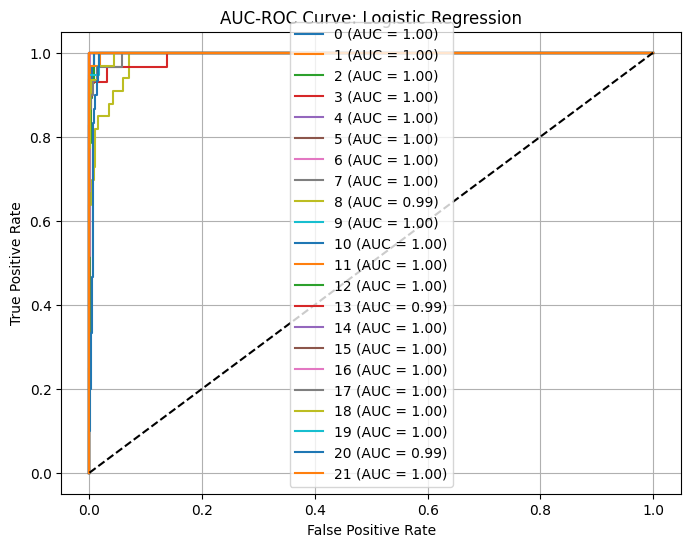

Skipping SVM: predict_proba not supported.


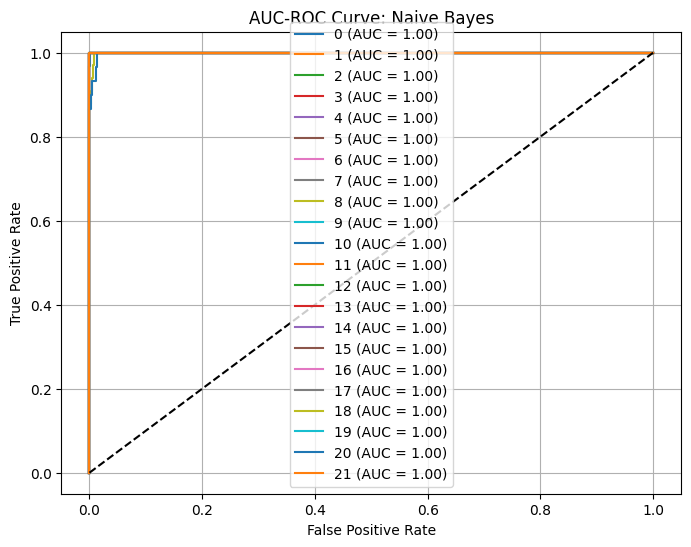

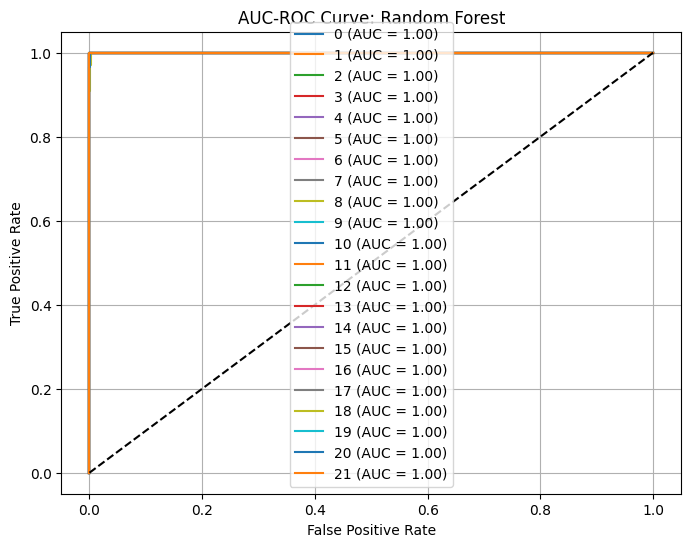

In [52]:
# Binarize labels for multi-class AUC-ROC
y_test_bin = label_binarize(y_test, classes=sorted(y_train.unique()))
n_classes = y_test_bin.shape[1]

# Simple ROC plotter
def plot_model_roc(model, name):
    try:
        ovr = OneVsRestClassifier(model)
        ovr.fit(X_train, y_train)
        y_score = ovr.predict_proba(X_test)

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f"{i} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.title(f"AUC-ROC Curve: {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid()
        plt.show()

    except AttributeError:
        print(f"Skipping {name}: predict_proba not supported.")

# Plotting each model
plot_model_roc(log_reg, "Logistic Regression")
plot_model_roc(svm, "SVM")  # This will print a skip message unless you change svm = SVC(probability=True)
plot_model_roc(nb, "Naive Bayes")
plot_model_roc(rf, "Random Forest")
# plot_model_roc(xgb, "XGBoost")

In [53]:
# Store trained model instances in dict
trained_models = {
    "Logistic Regression": log_reg,
    "Naive Bayes": nb,
    "SVM": svm,
    "Random Forest": rf,
}

In [54]:
# Perform inference on model to verify it

sample_row = crop_df.iloc[[2]]
sample_row_features = sample_row.drop(columns=["label", "encoded_label"])

sample_prediction = encoder.inverse_transform(rf.predict(sample_row_features))[0]
sample_actual = str(sample_row.iloc[0]["label"])

print(f"Predicted label: {sample_prediction}")
print(f"Actual label: {sample_actual}")

Predicted label: rice
Actual label: rice


In [55]:
# Create a directory to store models if it doesn't exist
os.makedirs("../models", exist_ok=True)

In [56]:
# Save each model with proper naming
for model_name, model in trained_models.items():
    # Remove spaces from filename
    filename = f"../models/{model_name.replace(' ', '_').lower()}.pkl"
    joblib.dump(model, filename)
    print(f"Saved {model_name} to {filename}")

Saved Logistic Regression to ../models/logistic_regression.pkl
Saved Naive Bayes to ../models/naive_bayes.pkl
Saved SVM to ../models/svm.pkl
Saved Random Forest to ../models/random_forest.pkl
